In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras_self_attention import SeqSelfAttention
from math import sqrt
import matplotlib.pyplot as plt

2023-12-15 13:16:04.384282: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 13:16:04.430070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 13:16:04.430111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 13:16:04.431399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 13:16:04.439143: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 13:16:04.440135: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Load the dataset
train1 = pd.read_csv('/home/disi/ff/Datasets/Dataset_2/Train1.csv')
train2 = pd.read_csv('/home/disi/ff/Datasets/Dataset_2/Train2.csv')
test = pd.read_csv('/home/disi/ff/Datasets/Dataset_2/Test.csv')

In [3]:
# Combine training data
train_data = pd.concat([train1, train2])

In [4]:
# Select relevant features
features = ['Temperature', 'Humidity', 'Light']  # Update these names based on actual column names in your CSV
X_train = train_data[features]
X_test = test[features]
y_train = train_data[features]  # Assuming you want to predict the same features
y_test = test[features]

In [5]:
# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [6]:
# Define a function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences
time_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)


In [7]:
# Define the model with GRU and an Attention layer
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))
model.summary()

2023-12-15 13:17:40.699863: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/disi/anaconda3/envs/ff/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             13248     
                                                                 
 seq_self_attention (SeqSel  (None, 5, 64)             4161      
 fAttention)                                                     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 42564 (166.27 KB)
Trainable params: 42564 (166.27 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [9]:
# Train the model
model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
271/271 [==============================] - 7s 9ms/step - loss: 0.0047 - val_loss: 3.9777e-04
Epoch 2/20
271/271 [==============================] - 2s 7ms/step - loss: 0.0015 - val_loss: 2.9847e-04
Epoch 3/20
271/271 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 4.0774e-04
Epoch 4/20
271/271 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 3.6353e-04
Epoch 5/20
271/271 [==============================] - 2s 6ms/step - loss: 9.8593e-04 - val_loss: 4.4069e-04
Epoch 6/20
271/271 [==============================] - 2s 7ms/step - loss: 9.4634e-04 - val_loss: 4.0006e-04
Epoch 7/20
271/271 [==============================] - 2s 7ms/step - loss: 8.4409e-04 - val_loss: 2.8397e-04
Epoch 8/20
271/271 [==============================] - 2s 7ms/step - loss: 8.2928e-04 - val_loss: 4.9728e-04
Epoch 9/20
271/271 [==============================] - 2s 7ms/step - loss: 7.7135e-04 - val_loss: 2.7494e-04
Epoch 10/20
271/271 [=======================

In [10]:
# Evaluate the model
y_pred = model.predict(X_test_seq)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(y_test_seq, y_pred)

print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

305/305 [==============================] - 1s 2ms/step
Test MSE: 0.000
Test RMSE: 0.013
Test MAPE: 2257746766473.066


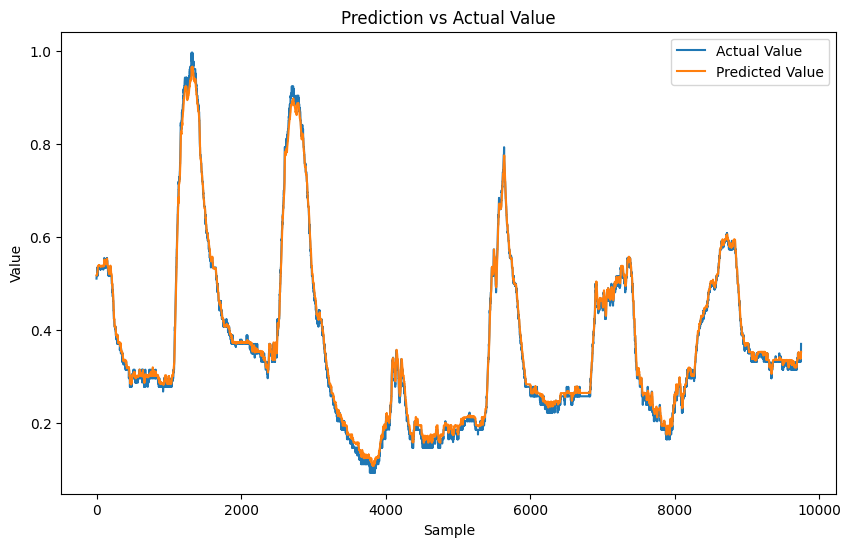

In [11]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[:, 0], label='Actual Value')
plt.plot(y_pred[:, 0], label='Predicted Value')
plt.title('Prediction vs Actual Value')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()